In [1]:
%pylab inline
import matplotlib.gridspec as gridspec
from astropy.table import Table,Column
import numpy as np
import matplotlib.pyplot as plt
import operator
import os
from astropy.cosmology import WMAP9 
import requests
import pandas as pd
from scipy import stats
import matplotlib.patches as patches
import scipy.stats.distributions as dist
from PIL import Image
import urllib, cStringIO
import random
import seaborn as sns
import uncertainties as unc  
import uncertainties.unumpy as unumpy  

sns.set_style("ticks")

#function for getting galaxy images
def get_image(url):
    file = cStringIO.StringIO(urllib.urlopen(url).read())
    img = Image.open(file)
    return img


mpl.rcParams['text.usetex']=True
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20 


Populating the interactive namespace from numpy and matplotlib


In [2]:
#load the data - #70,198 galaxies matched between COSMOS and UV
data=Table.read('../data/cosmos_uv_matched_catalog.fits')

#GZH vote fractions
p_features = 't01_smooth_or_features_a02_features_or_disk_weighted_fraction'
p_artifact = 't01_smooth_or_features_a03_star_or_artifact_weighted_fraction'
p_clumpy_no = 't12_clumpy_a02_no_weighted_fraction'
p_edgeon_no = 't02_edgeon_a02_no_weighted_fraction'
N_edgeon = 't02_edgeon_total_weight'
f_obv = 't05_bulge_prominence_a03_obvious_weighted_fraction'
f_dom = 't05_bulge_prominence_a04_dominant_weighted_fraction'
p_irregular = 't08_odd_feature_a04_irregular_weighted_fraction'
p_merger = 't08_odd_feature_a06_merger_weighted_fraction'
p_odd = 't06_odd_a01_yes_weighted_fraction'


In [3]:
#define edges of redshift bins
z_edges=np.linspace(0.2,1.1,5)
z_centers = []
for i in range(0,len(z_edges)-1):
    center = (z_edges[i]+z_edges[i+1])/2
    z_centers.append(round(center,2))

z_edges,z_centers

(array([ 0.2  ,  0.425,  0.65 ,  0.875,  1.1  ]), [0.31, 0.54, 0.76, 0.99])

In [4]:
#define edges of mass bins
m_edges = [10.1,10.4,10.7,11,11.3]
m_centers = []
for i in range(0,len(m_edges)-1):
    center = (m_edges[i]+m_edges[i+1])/2
    m_centers.append(round(center,2))

m_edges,m_centers

([10.1, 10.4, 10.7, 11, 11.3], [10.25, 10.55, 10.85, 11.15])

In [5]:
m_range = (data['mass_med']>=m_edges[0]) & (data['mass_med']<=m_edges[len(m_edges)-1]) 
data = data[m_range] #limit to galaxies in mass range

In [6]:
#remove mergers and irregulars from sample 
mergers = (data[p_odd]>0.5) & (data[p_merger]>0.5)
irregulars = (data[p_odd]>0.5) & (data[p_irregular]>0.5)
artifact = (data[p_artifact]>0.5)
edgeon = (data[N_edgeon]>10) & (data[p_edgeon_no]<0.3)
m = len(data[mergers])
i = len(data[irregulars])
a = len(data[artifact])
eo = len(data[edgeon])
alldata = (data['classification']!=2) #cheap trick to set a group of all the data because just data[!=(mergers|irregulars)] doesn't cut it

data = data[alldata!=(mergers|irregulars|artifact|edgeon)]

print 'removed {} mergers, {} irregulars, {} edgeon disks, and {} artifacts, leaving a sample of {}'.format(m,i,eo,a,len(data))


removed 542 mergers, 219 irregulars, 1113 edgeon disks, and 330 artifacts, leaving a sample of 20811


In [7]:
#define red sequence
red_sequence = (data['activity_type']==1) #activity type if evolving with redshift, classification if not
blue_cloud = (data['activity_type']==0)
#red_sequence = (data['classification']==0) #activity type if evolving with redshift, classification if not
#blue_cloud = (data['classification']==1)

#define disks (raw)
disks = (data[p_features]>=0.25)
ellipticals = (data[p_features]<0.25)

states = ['RD','RE','BD','BE']


In [8]:
#load incompleteness values for different thresholds 
I=Table.read('../data/ferengi_Inc.fits')

I

threshold,slope,intercept,slope_err,intercept_err,E_slope,E_intercept,E_slope_err,E_intercept_err
float64,float64,float64,float64,float64,float64,float64,float64,float64
0.25,-0.469286714638,1.1397862307,0.0531316988255,0.0196808837046,0.196990691255,0.941349422399,0.0224690202579,0.00832546930179
0.3,-0.972074430269,1.28966655874,0.0415274228413,0.0150733207304,0.325076030193,0.903083683559,0.0152539126615,0.00534036542556


In [41]:
#binomial confidence intervals, default 1-sigma 
def get_error(k,n,c=0.683):
    p_lower = dist.beta.ppf((1-c)/2.,k+1,n-k+1)
    p_upper = dist.beta.ppf(1-(1-c)/2.,k+1,n-k+1)
    return p_lower,p_upper

def prop_error(N,Nerr,xi,xierr):
    x=unumpy.uarray((N,Nerr))
    y=unumpy.uarray((xi,xierr))
    z=x/y
    errz=unumpy.std_devs(z)
    return errz
def prop_error_xi(z,slope,intercept,slope_err,intercept_err):
    m = unumpy.uarray((slope,slope_err))
    b = unumpy.uarray((intercept,intercept_err))
    redshft = unumpy.uarray((z,0)) #no err. on redhsift
    
    f = m*redshft+b
    errf = unumpy.std_devs(f)
    return errf

def prop_error_sum(vals,val_errs):
    x = unumpy.uarray((vals,val_errs))
    z = np.sum(x)
    errz = unumpy.std_devs(z)
    return errz

In [94]:
Inc

threshold,slope,intercept,slope_err,intercept_err,E_slope,E_intercept,E_slope_err,E_intercept_err
float64,float64,float64,float64,float64,float64,float64,float64,float64
0.3,-0.972074430269,1.28966655874,0.0415274228413,0.0150733207304,0.325076030193,0.903083683559,0.0152539126615,0.00534036542556


In [100]:
def get_results(t,corrected=True):
    #t = threshold for disk detection. f_features >=t = disk, <t = elliptical
    Inc = I[I['threshold']==t] #incompleteness values for this threshold
    xi = [z*Inc['slope'][0] + Inc['intercept'][0] for z in z_centers]
    xi_e = [z*Inc['E_slope'][0] + Inc['intercept'][0] for z in z_centers]
    
    #xi errors at each redshift, errors from fit 
    xi_err = [prop_error_xi(z,Inc['E_slope'][0],Inc['E_intercept'][0],Inc['E_slope_err'][0],Inc['E_intercept_err'][0]) for z in z_centers]
    xi_e_err = [prop_error_xi(z,Inc['E_slope'][0],Inc['E_intercept'][0],Inc['E_slope_err'][0],Inc['E_intercept_err'][0]) for z in z_centers]
    
    #xi errors directly from I measurements
    #xi_err = [0,.06,.067,.069]
    #xi_e_err = [0,.06,.067,.069]

    #define disks (raw)
    disks = (data[p_features]>=t)
    ellipticals = (data[p_features]<t)
    
    states = ['RD','RE','BD','BE']
    #start: count the raw numbers of red disks, blue disks, red ellipticals, blue ellipticals in specified redshift bins
    results={} #set dictionary to store results of numbers and fractions of each state in each mass bin
    results['z_centers']=z_centers
    for m in m_centers:
        results[m]={}
        for state in states:
            results[m][state]=[] #record number of galaxies at each redshift 
            results[m]['{}_err'.format(state)]=[] #error in number of galaxies 
            results[m]['f_{}'.format(state)]=[] #record fraction of galaxies at each redshift 
            results[m]['f_{}_err'.format(state)]=[] #record error in fraction

        results[m]['f_RID']=[]
        results[m]['f_DIR']=[]
        results[m]['f_RID_err']=[]
        results[m]['f_DIR_err']=[]
        
    for m in range(0,len(m_edges)-1):
        m_bin = (data['mass_med']>m_edges[m]) & (data['mass_med']<=m_edges[m+1]) #set mass bin 
        for z in range(0,len(z_edges)-1):
            z_bin = (data['Z_BEST']>z_edges[z]) & (data['Z_BEST']<=z_edges[z+1]) #set redshift bin
        
        #now split into populations: 
            if corrected==False: #no correction applied
                RD = float(len(data[z_bin & m_bin & red_sequence & disks])) #number of red disks at this mass, redshift
                RE = float(len(data[z_bin & m_bin & red_sequence & ellipticals]))
                BD = float(len(data[z_bin & m_bin & blue_cloud & disks]))
                BE = float(len(data[z_bin & m_bin & blue_cloud & ellipticals]))
                
                RD_err = 0
                RE_err = 0
                BD_err = 0
                BE_err = 0 
                
            else: #apply correction, propogate error from xi 
                RD = len(data[z_bin & m_bin & red_sequence & disks])/xi[z] #corrected number of RD galaxies
                RE = len(data[z_bin & m_bin & red_sequence & ellipticals])/xi_e[z] #corrected number of RE galaxies
                BD = len(data[z_bin & m_bin & blue_cloud & disks])/xi[z] #corrected number of BD galaxies
                BE = len(data[z_bin & m_bin & blue_cloud & ellipticals])/xi_e[z] #corrected number of BD galaxies
                
                RD_err = prop_error(RD,1./np.sqrt(RD),xi[z],xi_err[z])
                RE_err = prop_error(RE,1./np.sqrt(RE),xi_e[z],xi_e_err[z])
                BD_err = prop_error(BD,1./np.sqrt(BD),xi[z],xi_err[z])
                BE_err = prop_error(BE,1./np.sqrt(BE),xi_e[z],xi_e_err[z])
                
                
            all_red = RD + RE #total number of red galaxies
            all_red_err = prop_error_sum([RD,RE],[RD_err,RE_err])
            
            all_blue = BD + BE #total number of blue galaxies
            all_blue_err = prop_error_sum([BD,BE],[BD_err,BE_err])
            
            all_disks = RD + BD #total number of disk galaxies
            all_disks_err = prop_error_sum([RD,BD],[RD_err,BE_err])
            
            total = RD + RE + BD + BE #total number of galaxies in redshift,mass bin 
            total_err = prop_error_sum([RD,RE,BD,BE],[RD_err,RE_err,BD_err,BE_err])
            
            #raw numbers:
            results[m_centers[m]]['RD'].append(RD)
            results[m_centers[m]]['RE'].append(RE)
            results[m_centers[m]]['BD'].append(BD)
            results[m_centers[m]]['BE'].append(BE)
            
            #errors in raw numbers:
            #RD
            results[m_centers[m]]['RD_err'].append(RD_err)
            results[m_centers[m]]['RE_err'].append(RE_err)
            results[m_centers[m]]['BD_err'].append(BD_err)
            results[m_centers[m]]['BE_err'].append(BE_err)
            
            #fractions of populations:
            results[m_centers[m]]['f_RD'].append(round(RD/total,3))
            results[m_centers[m]]['f_RE'].append(round(RE/total,3))
            results[m_centers[m]]['f_BD'].append(round(BD/total,3))
            results[m_centers[m]]['f_BE'].append(round(BE/total,3))
            
            #errors in fraction of populations
            results[m_centers[m]]['f_RD_err'].append(prop_error(RD,RD_err,total,total_err))
            results[m_centers[m]]['f_RE_err'].append(prop_error(RE,RE_err,total,total_err))
            results[m_centers[m]]['f_BD_err'].append(prop_error(BD,BD_err,total,total_err))
            results[m_centers[m]]['f_BE_err'].append(prop_error(RE,RE_err,total,total_err))

            
            #f_rid
            results[m_centers[m]]['f_RID'].append(round(RD/(RD+BD),3))
            results[m_centers[m]]['f_RID_err'].append(prop_error(RD,RD_err,all_disks,all_disks_err))

            #f_dir
            results[m_centers[m]]['f_DIR'].append(round(RD/(RD+RE),3))
            results[m_centers[m]]['f_DIR_err'].append(prop_error(RD,RD_err,all_red,all_red_err))

    return results

In [ ]:
results = get_results(0.3)
#save results to send
import pickle
with open('results.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)


## Uncorrected numbers of RD, RE, BD, BE

In [69]:
Inc

threshold,slope,intercept,slope_err,intercept_err,E_slope,E_intercept,E_slope_err,E_intercept_err
float64,float64,float64,float64,float64,float64,float64,float64,float64
0.3,-0.972074430269,1.28966655874,0.0415274228413,0.0150733207304,0.325076030193,0.903083683559,0.0152539126615,0.00534036542556


## Corrected numbers of RD, RE, BD, BE

In [107]:
for m in m_centers:
    massdata = pd.DataFrame(index=states, columns=z_centers,data=np.zeros(shape=(4,4)))
    for state in states:
        for i,z in enumerate(z_centers):
            massdata[z][state]=round(results[m][state][i],0)
    print '{}:'.format(m)
    print massdata

10.25:
    0.31  0.54  0.76  0.99
RD    67    30    65    52
RE   142   179   365   132
BD   416   582  1369  1922
BE   106   269   433   313
10.55:
    0.31  0.54  0.76  0.99
RD    77    60   151   134
RE   134   186   520   329
BD   355   498  1109  1436
BE    49   127   349   223
10.85:
    0.31  0.54  0.76  0.99
RD    54    52   214   238
RE    92   119   442   374
BD   225   347   719   877
BE    27    59   165   141
11.15:
    0.31  0.54  0.76  0.99
RD    29    43   162   217
RE    53    74   223   198
BD    74   127   274   385
BE     5    12    42    39


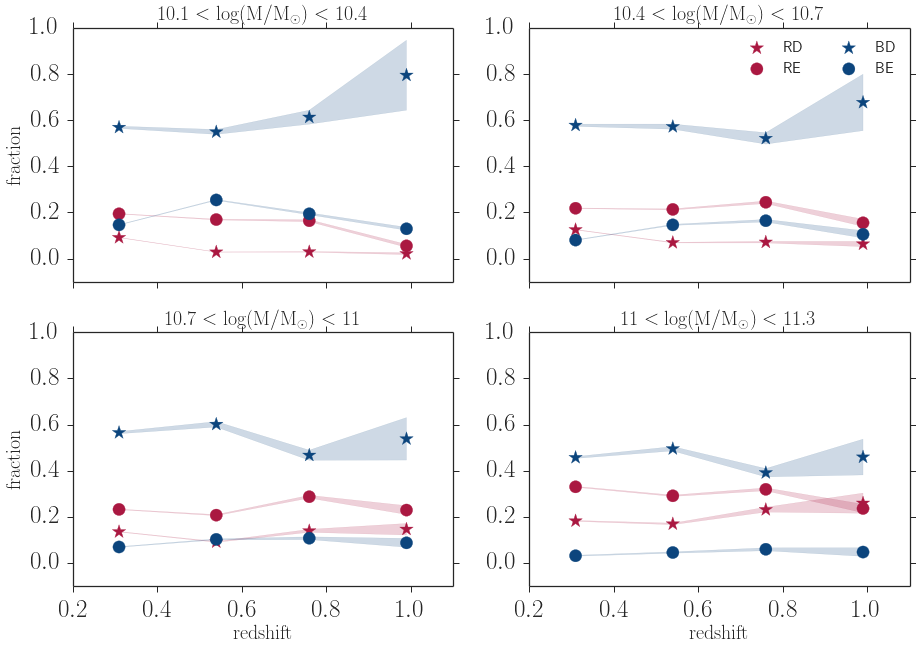

In [102]:
f=plt.figure(figsize=(15,10))
gs=gridspec.GridSpec(2,2)

#states order btw: RD, RE, BD, BE
mkr=['*','o','*','o']
#clr = ['#008744','#0c457d','#aa1841','#54235c']
clr = ['#aa1841','#aa1841','#0c457d','#0c457d']
mss = [200,150,200,150]
ax=plt.subplot(gs[0,0])
m=0 #lowest mass
for i,state in enumerate(states):
    hi_val = [a+b for a,b in zip(results[m_centers[m]]['f_{}'.format(state)],results[m_centers[m]]['f_{}_err'.format(state)])]
    lo_val = [a-b for a,b in zip(results[m_centers[m]]['f_{}'.format(state)],results[m_centers[m]]['f_{}_err'.format(state)])]
    plt.fill_between(results['z_centers'],hi_val,lo_val,alpha=.2,color=clr[i])
    plt.scatter(results['z_centers'],results[m_centers[m]]['f_{}'.format(state)],label=state,marker=mkr[i],s=mss[i],color=clr[i])
    plt.title('$\mathrm{%s<log(M/M_{\odot})<%s}$'%(m_edges[m],m_edges[m+1]),fontsize=20)
    plt.tick_params(labelbottom='off')
    plt.ylim(-.1,1)
    plt.ylabel('$\mathrm{fraction}$',fontsize=20)

ax=plt.subplot(gs[0,1])
m=1
for i,state in enumerate(states):
    hi_val = [a+b for a,b in zip(results[m_centers[m]]['f_{}'.format(state)],results[m_centers[m]]['f_{}_err'.format(state)])]
    lo_val = [a-b for a,b in zip(results[m_centers[m]]['f_{}'.format(state)],results[m_centers[m]]['f_{}_err'.format(state)])]
    plt.fill_between(results['z_centers'],hi_val,lo_val,alpha=.2,color=clr[i])
    plt.scatter(results['z_centers'],results[m_centers[m]]['f_{}'.format(state)],label=state,marker=mkr[i],s=mss[i],color=clr[i])
    plt.legend(fontsize=15,ncol=2)
    plt.title('$\mathrm{%s<log(M/M_{\odot})<%s}$'%(m_edges[m],m_edges[m+1]),fontsize=20)
    plt.tick_params(labelbottom='off')
    plt.ylim(-.1,1)

ax=plt.subplot(gs[1,0])
m=2
for i,state in enumerate(states):
    hi_val = [a+b for a,b in zip(results[m_centers[m]]['f_{}'.format(state)],results[m_centers[m]]['f_{}_err'.format(state)])]
    lo_val = [a-b for a,b in zip(results[m_centers[m]]['f_{}'.format(state)],results[m_centers[m]]['f_{}_err'.format(state)])]
    plt.fill_between(results['z_centers'],hi_val,lo_val,alpha=.2,color=clr[i])
    plt.scatter(results['z_centers'],results[m_centers[m]]['f_{}'.format(state)],label=state,marker=mkr[i],s=mss[i],color=clr[i])
    plt.title('$\mathrm{%s<log(M/M_{\odot})<%s}$'%(m_edges[m],m_edges[m+1]),fontsize=20)
    plt.ylim(-.1,1)
    plt.xlabel('$\mathrm{redshift}$',fontsize=20)
    plt.ylabel('$\mathrm{fraction}$',fontsize=20)

ax=plt.subplot(gs[1,1])
m=3
for i,state in enumerate(states):
    hi_val = [a+b for a,b in zip(results[m_centers[m]]['f_{}'.format(state)],results[m_centers[m]]['f_{}_err'.format(state)])]
    lo_val = [a-b for a,b in zip(results[m_centers[m]]['f_{}'.format(state)],results[m_centers[m]]['f_{}_err'.format(state)])]
    plt.fill_between(results['z_centers'],hi_val,lo_val,alpha=.2,color=clr[i])
    plt.scatter(results['z_centers'],results[m_centers[m]]['f_{}'.format(state)],label=state,marker=mkr[i],s=mss[i],color=clr[i])
    plt.title('$\mathrm{%s<log(M/M_{\odot})<%s}$'%(m_edges[m],m_edges[m+1]),fontsize=20)
    plt.ylim(-.1,1)
    plt.xlabel('$\mathrm{redshift}$',fontsize=20)

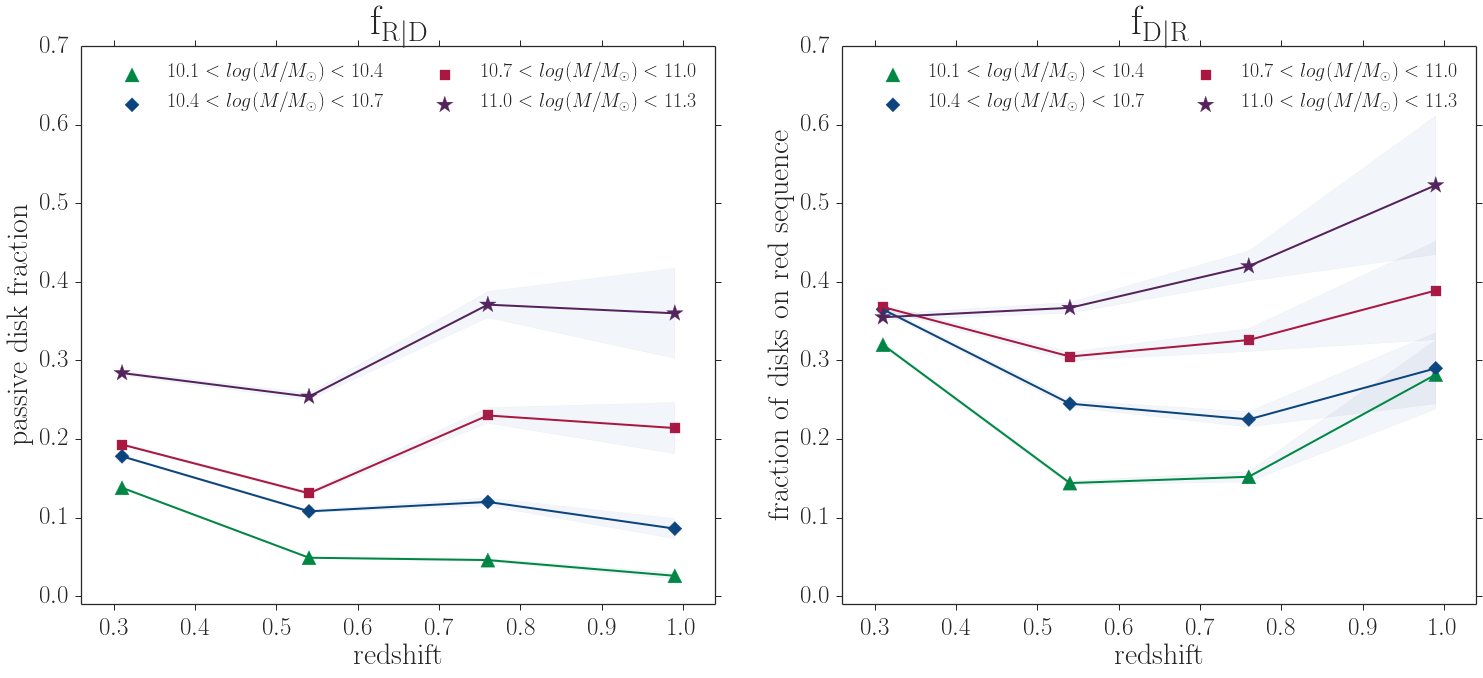

In [103]:
mpl.rcParams['xtick.labelsize'] = 25
mpl.rcParams['ytick.labelsize'] = 25 
results = corrected_results

f=plt.figure(figsize=(25,10))
gs=gridspec.GridSpec(1,2)
ax=plt.subplot(gs[0,1])
colors = ['#008744','#0c457d','#aa1841','#54235c']
markers = ['^','D','s','*']
msizes = [200,100,100,300]

ax = plt.subplot(gs[0,1])

for i in range(0,len(m_edges)-1):
    plt.plot(results['z_centers'],results[m_centers[i]]['f_DIR'],color=colors[i],lw=2)
    plt.scatter(results['z_centers'],results[m_centers[i]]['f_DIR'],marker=markers[i],s=msizes[i],color=colors[i],label=r'${:.1f}<log(M/M_\odot)<{:.1f}$'.format(m_edges[i],m_edges[i+1]))
    hi_val = [a+b for a,b in zip(results[m_centers[i]]['f_DIR'],results[m_centers[i]]['f_DIR_err'])]
    lo_val = [a-b for a,b in zip(results[m_centers[i]]['f_DIR'],results[m_centers[i]]['f_DIR_err'])]
    plt.fill_between(results['z_centers'],hi_val,lo_val,alpha=.07)
plt.xlim(z_centers[0]-.05,z_centers[-1]+.05)
plt.xlabel(r'$\mathrm{redshift}$',fontsize = 30)
plt.ylabel(r'$\mathrm{fraction~of~disks~on~red~sequence}$', fontsize=30)
plt.title(r'$\mathrm{f_{D|R}}$', fontsize=40)
plt.legend(fontsize=20,ncol=2)
plt.ylim(-.01,.7)

ax = plt.subplot(gs[0,0])
for i in range(0,len(m_edges)-1):
    plt.plot(results['z_centers'],results[m_centers[i]]['f_RID'],color=colors[i],lw=2)
    plt.scatter(results['z_centers'],results[m_centers[i]]['f_RID'],marker=markers[i],s=msizes[i],color=colors[i],label=r'${:.1f}<log(M/M_\odot)<{:.1f}$'.format(m_edges[i],m_edges[i+1]))
    hi_val = [a+b for a,b in zip(results[m_centers[i]]['f_RID'],results[m_centers[i]]['f_RID_err'])]
    lo_val = [a-b for a,b in zip(results[m_centers[i]]['f_RID'],results[m_centers[i]]['f_RID_err'])]
    plt.fill_between(results['z_centers'],hi_val,lo_val,alpha=.07)
plt.xlim(z_centers[0]-.05,z_centers[-1]+.05)
plt.ylim(-.01,.7)
#plt.gca().invert_xaxis()
plt.xlabel(r'$\mathrm{redshift}$',fontsize = 30)
plt.ylabel(r'$\mathrm{passive~disk~fraction}$', fontsize=30)
plt.title(r'$\mathrm{f_{R|D}}$', fontsize=40)
plt.legend(fontsize=20,ncol=2)
#plt.savefig('../writeup/figures/red_disk_fraction_mass_limited.pdf')